In [1]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install datasets torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 103.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset
import spacy
import random
import numpy as np

# Fix randomness so results are same at each run
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Upload Spacy language Models
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

# Tokenization functions
def tokenize_de(text):
    # Seperate German text into words
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    # Same for english
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [3]:
!pip install torch==2.3.1 torchtext==0.18.0

In [4]:
from torchtext.vocab import build_vocab_from_iterator

# Download DataSet
dataset = load_dataset("bentrevett/multi30k")

print("Dataset is ready:", dataset)

# 2. Sözlük (Vocab) Oluşturma Yardımcı Fonksiyonu
def yield_tokens(data_iter, language):
    for example in data_iter:
        if language == 'de':
            yield tokenize_de(example['de'])
        else:
            yield tokenize_en(example['en'])

# Special tokens:
# <unk>: Unkown words
# <pad>: To equalize short sentences
# <sos>: Start of Sentence
# <eos>: End of Sentence
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

print("Creating dictionaries... (Could take about 2 minutes)")

# German dictionary
vocab_de = build_vocab_from_iterator(yield_tokens(dataset['train'], 'de'),
                                     min_freq=2,
                                     specials=special_symbols)
vocab_de.set_default_index(vocab_de['<unk>'])

# English dictionary
vocab_en = build_vocab_from_iterator(yield_tokens(dataset['train'], 'en'),
                                     min_freq=2,
                                     specials=special_symbols)
vocab_en.set_default_index(vocab_en['<unk>'])

print(f"German word count: {len(vocab_de)}")
print(f"English word count: {len(vocab_en)}")

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authe

Dataset is ready: DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})
Creating dictionaries... (Could take about 2 minutes)
German word count: 8014
English word count: 6191


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fix
PAD_IDX = vocab_de['<pad>']
SOS_IDX = vocab_de['<sos>']
EOS_IDX = vocab_de['<eos>']

# Function working on text
def data_process(filepaths, text_transform_src, text_transform_tgt):
    # Get the sentence -> Tokenize -> Convert into numbers -> add  to begining SOS,  EOS to ending -> TMake tensor
    pass


def collate_batch(batch):
    src_list, tgt_list = [], []

    for item in batch:
        # German (Source)
        src_tokens = tokenize_de(item['de'])
        src_indices = [vocab_de[token] for token in src_tokens]
        src_tensor = torch.tensor([SOS_IDX] + src_indices + [EOS_IDX], dtype=torch.long)

        # English (Target)
        tgt_tokens = tokenize_en(item['en'])
        tgt_indices = [vocab_en[token] for token in tgt_tokens]
        tgt_tensor = torch.tensor([SOS_IDX] + tgt_indices + [EOS_IDX], dtype=torch.long)

        src_list.append(src_tensor)
        tgt_list.append(tgt_tensor)

    # Padding
    src_batch = pad_sequence(src_list, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_list, padding_value=PAD_IDX)

    # In Q1 batch_first=True was used but here Pytorch tutorial standards are applied
    return src_batch.to(device), tgt_batch.to(device)

# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        # Word embedding layer
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # Bidirectional GRU (Read from both start to end and end to start)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)

        # A linear layer to adjust Encoder output to Decoder size
        # (Çünkü Encoder çift yönlü olduğu için boyutu 2 katıdır)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [sentence length, batch size]

        embedded = self.dropout(self.embedding(src))

        # outputs: Outputs produced for each word (Attention)
        # hidden: Summary information
        outputs, hidden = self.rnn(embedded)

        # adjust hidden size (Forward + Backward)
        # hidden[-2,:,:] -> final state going forward
        # hidden[-1,:,:] -> final state going backward
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        return outputs, hidden

In [7]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, method='additive'):
        super().__init__()
        self.method = method
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        # ADDITIVE (Bahdanau)
        if method == 'additive':
            self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
            self.v = nn.Linear(dec_hid_dim, 1, bias=False)

        # MULTIPLICATIVE (Luong)
        elif method == 'multiplicative':
            self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        # SCALED DOT-PRODUCT
        elif method == 'dot':
            # Since Encoder output (1024) and Decoder (512) doesn't fit with each other
            # An equalizing layer is added here
            self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch size, dec_hid_dim]
        # encoder_outputs: [src len, batch size, enc_hid_dim * 2]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)

        # Encoder outputs [batch size, src len, enc_hid_dim * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        attention = None

        if self.method == 'additive':
            energy = torch.tanh(self.attn(torch.cat((hidden_expanded, encoder_outputs), dim=2)))
            attention = self.v(energy).squeeze(2)

        elif self.method == 'multiplicative':
            transformed_enc = self.attn(encoder_outputs)
            # hidden: [batch, 1, dec_hid], transformed: [batch, src, dec_hid] -> [batch, dec_hid, src] (transpose)
            score = torch.bmm(hidden.unsqueeze(1), transformed_enc.permute(0, 2, 1))
            attention = score.squeeze(1)

        elif self.method == 'dot':
            # Dimension equalizing (1024 -> 512)
            projected_enc = self.attn(encoder_outputs)

            # Dot Product
            # hidden: [batch, 1, 512]
            # projected_enc (transpose): [batch, 512, src_len]
            energy = torch.bmm(hidden.unsqueeze(1), projected_enc.permute(0, 2, 1))

            # Scale (Dividing - for stability)
            scale = torch.sqrt(torch.tensor(self.dec_hid_dim, dtype=torch.float32)).to(hidden.device)
            attention = (energy / scale).squeeze(1)

        return F.softmax(attention, dim=1)

In [8]:
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input: [batch size]
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        #  CALCULATE ATTENTION
        if hidden.dim() == 3:
            hidden = hidden.squeeze(0)

        a = self.attention(hidden, encoder_outputs) # [batch size, src len]
        a = a.unsqueeze(1) # [batch size, 1, src len]

        # WEIGHTED SUM
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)

        # RNN INPUT
        rnn_input = torch.cat((embedded, weighted), dim=2)

        # RNN STEP
        # RNN wants [1, batch, dim], that's why we unsqueeze
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        # WORD PREDICTION
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        # Return [batch, dim] to not run inot any errors in next steps
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [src len, batch size]
        # trg: [trg len, batch size]

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor to keep results
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Encoder
        encoder_outputs, hidden = self.encoder(src)

        # First inout is always <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            # Decoder (Produce a word)
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output

            # Teacher Forcing (While training sometimes give the real answer and sometimes give prediction)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

In [10]:
def build_model(attention_type='additive'):
    INPUT_DIM = len(vocab_de)
    OUTPUT_DIM = len(vocab_en)
    ENC_EMB_DIM = 256
    DEC_EMB_DIM = 256
    ENC_HID_DIM = 512
    DEC_HID_DIM = 512
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5

    # Pick Attention
    attn = Attention(ENC_HID_DIM, DEC_HID_DIM, method=attention_type)

    # Set up Encoder & Decoder
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

    # Unite
    model = Seq2Seq(enc, dec, device).to(device)

    # Weights (For fast learning)
    def init_weights(m):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)
    model.apply(init_weights)

    return model

In [11]:
import time
import math

# Training function
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        # trg: [trg len, batch size]
        # output: [trg len, batch size, output dim]
        output = model(src, trg)

        # While calculating Loss first token (<sos>) is not considered because it is expilicilty given
        output_dim = output.shape[-1]

        # Flatten işlemi: Loss function asks for 2D input
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Clipping to prevent Exploding Gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluating
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) # 0: No Teacher Forcing

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Time calculation helper
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
# Building model (Additive)
print("--- MODEL 1: ADDITIVE (BAHDANAU) ATTENTION ---")
model_additive = build_model('additive')

# Setting
optimizer = optim.Adam(model_additive.parameters())

# ignore <pad> token
TRG_PAD_IDX = vocab_en['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# Start training
N_EPOCHS = 10 # Needs to be increased for actual development
CLIP = 1

best_valid_loss = float('inf')

# Keep the results
history_additive = {'train_loss': [], 'val_loss': [], 'ppl': []}

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model_additive, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model_additive, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Save the best model (For reporting)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_additive.state_dict(), 'model_additive.pt')

    # Perplexity (PPL) = exp(loss)
    ppl = math.exp(valid_loss)
    history_additive['train_loss'].append(train_loss)
    history_additive['val_loss'].append(valid_loss)
    history_additive['ppl'].append(ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {ppl:7.3f}')

--- MODEL 1: ADDITIVE (BAHDANAU) ATTENTION ---
Epoch: 01 | Time: 1m 46s
	Train Loss: 4.233 | Train PPL:  68.947
	 Val. Loss: 3.821 |  Val. PPL:  45.638
Epoch: 02 | Time: 1m 42s
	Train Loss: 2.948 | Train PPL:  19.072
	 Val. Loss: 3.393 |  Val. PPL:  29.766
Epoch: 03 | Time: 1m 41s
	Train Loss: 2.400 | Train PPL:  11.024
	 Val. Loss: 3.271 |  Val. PPL:  26.348
Epoch: 04 | Time: 1m 41s
	Train Loss: 2.035 | Train PPL:   7.655
	 Val. Loss: 3.283 |  Val. PPL:  26.644
Epoch: 05 | Time: 1m 41s
	Train Loss: 1.756 | Train PPL:   5.792
	 Val. Loss: 3.318 |  Val. PPL:  27.597
Epoch: 06 | Time: 1m 41s
	Train Loss: 1.553 | Train PPL:   4.728
	 Val. Loss: 3.406 |  Val. PPL:  30.130
Epoch: 07 | Time: 1m 41s
	Train Loss: 1.418 | Train PPL:   4.129
	 Val. Loss: 3.408 |  Val. PPL:  30.210
Epoch: 08 | Time: 1m 41s
	Train Loss: 1.301 | Train PPL:   3.673
	 Val. Loss: 3.564 |  Val. PPL:  35.302
Epoch: 09 | Time: 1m 41s
	Train Loss: 1.192 | Train PPL:   3.294
	 Val. Loss: 3.709 |  Val. PPL:  40.796
Epoch: 1

In [13]:
# --- MODEL 2: MULTIPLICATIVE (LUONG) ATTENTION ---
print("\n--- MODEL 2: MULTIPLICATIVE (LUONG) ATTENTION ---")
model_mult = build_model('multiplicative') # changed the name
optimizer = optim.Adam(model_mult.parameters())
history_mult = {'train_loss': [], 'val_loss': [], 'ppl': []}

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model_mult, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model_mult, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_mult.state_dict(), 'model_multiplicative.pt')

    ppl = math.exp(valid_loss)
    history_mult['train_loss'].append(train_loss)
    history_mult['val_loss'].append(valid_loss)
    history_mult['ppl'].append(ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {ppl:7.3f}')


# --- MODEL 3: SCALED DOT-PRODUCT ATTENTION ---
print("\n--- MODEL 3: SCALED DOT-PRODUCT ATTENTION ---")
model_dot = build_model('dot')
optimizer = optim.Adam(model_dot.parameters())
history_dot = {'train_loss': [], 'val_loss': [], 'ppl': []}

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model_dot, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model_dot, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_dot.state_dict(), 'model_dot.pt')

    ppl = math.exp(valid_loss)
    history_dot['train_loss'].append(train_loss)
    history_dot['val_loss'].append(valid_loss)
    history_dot['ppl'].append(ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {ppl:7.3f}')


--- MODEL 2: MULTIPLICATIVE (LUONG) ATTENTION ---
Epoch: 01 | Time: 1m 34s
	Train Loss: 4.471 | Train PPL:  87.449
	 Val. Loss: 4.156 |  Val. PPL:  63.810
Epoch: 02 | Time: 1m 34s
	Train Loss: 3.369 | Train PPL:  29.041
	 Val. Loss: 3.644 |  Val. PPL:  38.243
Epoch: 03 | Time: 1m 34s
	Train Loss: 2.852 | Train PPL:  17.316
	 Val. Loss: 3.492 |  Val. PPL:  32.854
Epoch: 04 | Time: 1m 34s
	Train Loss: 2.543 | Train PPL:  12.723
	 Val. Loss: 3.391 |  Val. PPL:  29.709
Epoch: 05 | Time: 1m 34s
	Train Loss: 2.311 | Train PPL:  10.084
	 Val. Loss: 3.328 |  Val. PPL:  27.894
Epoch: 06 | Time: 1m 34s
	Train Loss: 2.120 | Train PPL:   8.334
	 Val. Loss: 3.389 |  Val. PPL:  29.641
Epoch: 07 | Time: 1m 35s
	Train Loss: 1.983 | Train PPL:   7.264
	 Val. Loss: 3.444 |  Val. PPL:  31.311
Epoch: 08 | Time: 1m 34s
	Train Loss: 1.877 | Train PPL:   6.537
	 Val. Loss: 3.471 |  Val. PPL:  32.178
Epoch: 09 | Time: 1m 35s
	Train Loss: 1.778 | Train PPL:   5.920
	 Val. Loss: 3.476 |  Val. PPL:  32.333
Epoc

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def translate_sentence(sentence, model, device, max_len=50):
    model.eval()

    # Tokenize the sentence
    if isinstance(sentence, str):
        tokens = tokenize_de(sentence)
    else:
        tokens = [token for token in sentence]

    # Convert into numerical IDs and make Tensor
    # Add start and end tokens
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [vocab_de[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # Move through Encoder
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    # Produce word by word (Decoder)
    trg_indexes = [vocab_en['<sos>']] # First input <sos>
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device) # Attention

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        # Decoder
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == vocab_en['<eos>']: # Stopping criteria
            break

    # Convert IDs back to words
    trg_tokens = [vocab_en.lookup_token(i) for i in trg_indexes]

    # discard <sos>
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    ax.tick_params(labelsize=15)

    # X axes: German (Sourca)
    # Y axes: English (Translation)
    # FixedLocator for more stability
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Source (German): Eine Frau, die in einer Küche eine Schale mit Essen hält.
Target (English): A woman holding a bowl of food in a kitchen.

--- Model: Additive (Bahdanau) ---
Prediction: A woman holding a food in a kitchen of food .


/tmp/ipython-input-371160482.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipython-input-371160482.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)


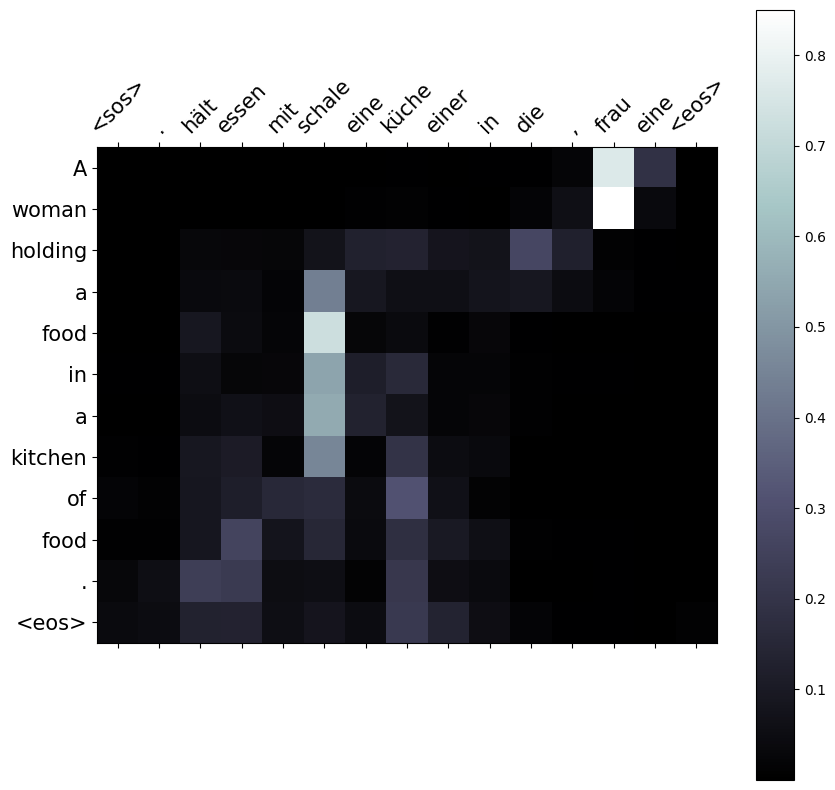


--- Model: Multiplicative (Luong) ---
Prediction: A woman holding a kitchen in a kitchen with a kitchen .


/tmp/ipython-input-371160482.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipython-input-371160482.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)


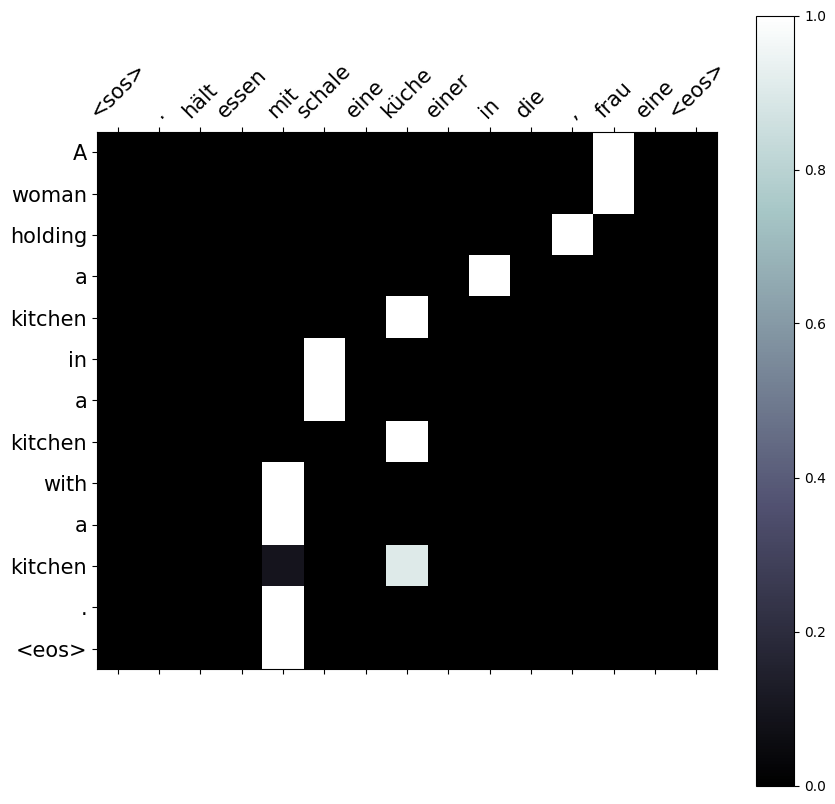


--- Model: Scaled Dot-Product ---
Prediction: A woman holding a food in a kitchen of food .


/tmp/ipython-input-371160482.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipython-input-371160482.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)


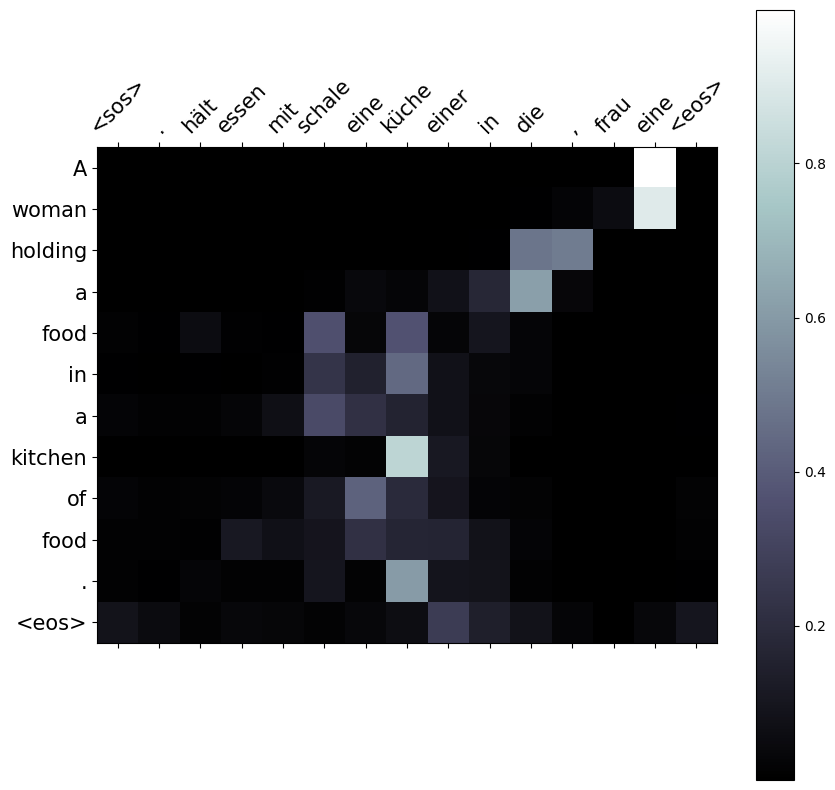

In [15]:
# Random sample from test set
example_idx = 12 # Could be any number betwwen 0 and 1000

src = dataset['test'][example_idx]['de']
trg = dataset['test'][example_idx]['en']

print(f'Source (German): {src}')
print(f'Target (English): {trg}')

# --- TRANSLATION WITH ADDITIVE MODEL ---
print("\n--- Model: Additive (Bahdanau) ---")
translation, attention = translate_sentence(src, model_additive, device)
print(f'Prediction: {" ".join(translation[:-1])}')
display_attention(tokenize_de(src), translation, attention)

# --- TRANSLATION WITH MULTIPLICATIVE MODEL ---
print("\n--- Model: Multiplicative (Luong) ---")
translation, attention = translate_sentence(src, model_mult, device)
print(f'Prediction: {" ".join(translation[:-1])}')
display_attention(tokenize_de(src), translation, attention)

# --- TRANSLATION WITH DOT-PRODUCT MODEL ---
print("\n--- Model: Scaled Dot-Product ---")
translation, attention = translate_sentence(src, model_dot, device)
print(f'Prediction: {" ".join(translation[:-1])}')
display_attention(tokenize_de(src), translation, attention)

In [16]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, model, device, max_len=50):
    trgs = []
    pred_trgs = []

    # Whole test data
    for datum in data:
        src = datum['de']
        trg = datum['en']

        # Predict
        pred_trg, _ = translate_sentence(src, model, device, max_len)

        # discard <eos> token at the end
        pred_trg = pred_trg[:-1]

        # tokenize real answer
        trg_tokenized = tokenize_en(trg)

        pred_trgs.append(pred_trg)
        trgs.append([trg_tokenized])

    return bleu_score(pred_trgs, trgs)

print("Calculating BLEU score... (This process could take up to 2 minutes)")

bleu_additive = calculate_bleu(dataset['test'], model_additive, device)
print(f'BLEU score (Additive): {bleu_additive*100:.2f}')

bleu_mult = calculate_bleu(dataset['test'], model_mult, device)
print(f'BLEU score (Multiplicative): {bleu_mult*100:.2f}')

bleu_dot = calculate_bleu(dataset['test'], model_dot, device)
print(f'BLEU score (Dot-Product): {bleu_dot*100:.2f}')

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Calculating BLEU score... (This process could take up to 2 minutes)
BLEU score (Additive): 30.94
BLEU score (Multiplicative): 29.72
BLEU score (Dot-Product): 31.47
